In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from embedding import Embedding
from forward_kinematic import ForwardKinematic as FKTrue
from forward_kinematics import ForwardKinematic
from dynamical_system import DynamicalSystem
from urdf_parser import URDFParser

In [2]:
# DS parameters
config_dim = 2
K = 1 * np.eye(config_dim)
D = 1.5*np.eye(config_dim)
# config_attractor = np.array([0.9, -0.9])
config_attractor = np.array([0.6, 0.15])

# Embedding parameters
# x = torch.tensor([[-0.5], [0.8], [0.]])
x = np.array([[-0.5], [1.8], [0.]])
mu = np.array([[[0.], [0.5], [0.]], [[0.], [0.51], [0.]]])
sigma = np.array([[[0.0112, 0.0024, 0], [0.0024, 0.0915, 0], [0, 0, 1]], [[0.01, 0.0034, 0], [0.0034, 0.0966, 0.], [0, 0, 1]]])


fkt = FKTrue(urdf_file='2_joints_arm.urdf', mu=mu, sigma=sigma)
fk = ForwardKinematic(urdf_file='2_joints_arm.urdf')
start = np.array([-0.4, 0.3])
fkt.test(start)
fk(start, derivation_order=2)

e = Embedding(dimension=2, x=x[np.newaxis, :, :], initial_mu=mu, initial_sigma=sigma, fk=fk)

ds = DynamicalSystem(stiffness=K, dissipation=D, attractor=config_attractor, embedding=e, dt=0.02)

In [31]:
start = np.array([-0.4, 0.3])
initial_speed = np.array([0.1, -0.1])
q = start
dq = initial_speed
positions = []
frequencies = []
for i in range(0,1000):
    start1 = time.time()
    q, dq = ds(q, dq)
    positions.append(q)
    frequencies.append(1/(time.time() - start1))
print(f'average execution frequency : {sum(frequencies)/len(frequencies):.4f} Hz')

ValueError: wrong argument size: expected 3, got 2
hint: The configuration vector is not of right size


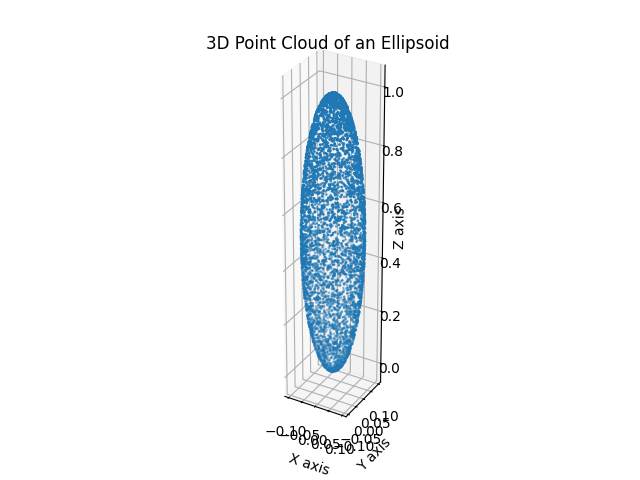

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture


%matplotlib widget
def generate_ellipsoid(a=0.1, b=0.1, c=0.5, num_points=1000):
    """
    Generates a 3D point cloud representing an ellipsoid.

    Parameters:
    a (float): Semi-axis length along the x-axis.
    b (float): Semi-axis length along the y-axis.
    c (float): Semi-axis length along the z-axis.
    num_points (int): Number of points in the point cloud.

    Returns:
    np.ndarray: Array of shape (num_points, 3) representing the point cloud.
    """
    # Generate random points on a unit sphere
    phi = np.random.uniform(0, 2 * np.pi, num_points)
    cos_theta = np.random.uniform(-1, 1, num_points)
    sin_theta = np.sqrt(1 - cos_theta**2)
    
    x = sin_theta * np.cos(phi)
    y = sin_theta * np.sin(phi)
    z = cos_theta
    
    # Scale points to the ellipsoid
    x *= a
    y *= b
    z *= c
    
    return np.vstack((x, y, z + c)).T

# Parameters for the ellipsoid
a = 0.1  # semi-axis length along the x-axis
b = 0.1  # semi-axis length along the y-axis
c = 0.5  # semi-axis length along the z-axis

# Generate the ellipsoid point cloud
point_cloud = generate_ellipsoid(a, b, c, num_points=5000)

# Plot the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_aspect('equal')
ax.set_title('3D Point Cloud of an Ellipsoid')
plt.show()


In [30]:
point_cloud[np.argmax(point_cloud[:, 2])]

array([0.00298311, 0.0029677 , 0.99955715])

In [4]:
from sklearn.mixture import GaussianMixture

GaussianMixture(point_cloud)

NameError: name 'point_cloud' is not defined